# Interoperability with C

Julia has a simple way to call C and Fortran functions in shared libraries, via the `ccall` function.

In [1]:
?ccall

search: ccall AbstractChannel



```
ccall((symbol, library) or function_pointer, ReturnType, (ArgumentType1, ...), ArgumentValue1, ...)
```

Call function in C-exported shared library, specified by `(function name, library)` tuple, where each component is a string or symbol.

Note that the argument type tuple must be a literal tuple, and not a tuple-valued variable or expression. Alternatively, `ccall` may also be used to call a function pointer, such as one returned by `dlsym`.

Each `ArgumentValue` to the `ccall` will be converted to the corresponding `ArgumentType`, by automatic insertion of calls to `unsafe_convert(ArgumentType, cconvert(ArgumentType, ArgumentValue))`. (See also the documentation for each of these functions for further details.) In most cases, this simply results in a call to `convert(ArgumentType, ArgumentValue)`.


We see that we must specify:

- the name of the function, as a Julia symbol or as a string
- and the name of the shared library where it lives;  these are given as an ordered pair (tuple)


- the return type of the function

- the argument types that the function accepts, as a tuple

- and the arguments themselves

A simple example is to call the clock function:

In [2]:
t = ccall( (:clock, "libc"), Int32, ())

6458707

In [3]:
typeof(t)

Int32

In [4]:
path = ccall( (:getenv, "libc"), Ptr{UInt8}, (Ptr{UInt8},), "PATH")

Ptr{UInt8} @0x00007ffd6e88bf2e

Here, `Ptr` denotes a pointer to the given type.

In [8]:
unsafe_string(path) # ENV["PATH"]

"/usr/local/bin:/usr/local/texlive/2014/bin/x86_64-linux:/usr/local/bin:/usr/bin:/bin:/sbin:/usr/sbin:/opt/julia/bin"

In [9]:
?unsafe_string

search: unsafe_string unsafe_store!



```
unsafe_string(p::Ptr{UInt8}, [length::Integer])
```

Copy a string from the address of a C-style (NUL-terminated) string encoded as UTF-8. (The pointer can be safely freed afterwards.) If `length` is specified (the length of the data in bytes), the string does not have to be NUL-terminated.

This function is labelled "unsafe" because it will crash if `p` is not a valid memory address to data of the requested length.

See also [`unsafe_wrap(String, p, [length])`](:func:`unsafe_wrap`), which takes a pointer and wraps a string object around it without making a copy.


C libraries tend to have large, repetitive, uniform API patterns and naming conventions.

Julia macros combined with `ccall` can make it easy to write wrapper interfaces.

Example: MPFR for `BigFloat`:

In [10]:
a = big"0.1"
b = big"0.3"
@which a + b

+(x::BigFloat, y::BigFloat) at mpfr.jl:205

In [11]:
@which sin(a)

sin(x::BigFloat) at mpfr.jl:610

Automated wrapper generation from headers is possible via the Clang.jl package: https://github.com/ihnorton/Clang.jl

# Interoperability with Python: the `PyCall` package

Coming from the Python ecosystem, the range of packages available in Julia can seem somewhat limited.
This is offset, however, by the ease of calling out to packages written in other languages from within Julia.

In particular, Python interoperability is very easy, thanks to the [`PyCall` package](https://github.com/stevengj/PyCall.jl). PyCall uses `ccall` to execute the same operations and C API from `libpython` that the Python interpreter would use.

In [12]:
using PyCall

`PyCall` has a high-level interface that is designed so that the "transport" between Julia and Python is transparent from the user's point of view. For example, to import the Python `math` module, we do

In [13]:
@pyimport math

We can now mix and match Python calls, labelled by the `math.` qualifier, and Julia calls:

In [14]:
math.sin(0.3*math.pi) - sin(0.3*pi) 

0.0

Array objects are automatically converted:

In [15]:
@pyimport numpy.random as nprandom
nprandom.rand(3,4)

3×4 Array{Float64,2}:
 0.206257  0.163541   0.182113  0.0853522
 0.453931  0.0601196  0.426293  0.2305   
 0.252272  0.279257   0.666667  0.13436  

Let's define a Julia function:

In [16]:
objective = x -> cos(x) - x

(::#1) (generic function with 1 method)

This is the Julia syntax for an anonymous function (like `lambda` in Python).

In [17]:
objective(3)

-3.989992496600445

We can pass this Julia function to a Python module:

In [18]:
@pyimport scipy.optimize as so
so.newton(objective, 1)

0.7390851332151607

In [19]:
objective(ans)

0.0

The main difference from Python is how to access member elements of Python structures.

Julia has ODE solvers in the `ODE.jl` and `Sundials.jl` packages. But we can also call Python solvers:

In [20]:
@pyimport scipy.integrate as integrate

In [21]:
f(x,t) = -x  

f (generic function with 1 method)

In [22]:
t = colon(0,0.1,10)

0.0:0.1:10.0

In [23]:
soln = integrate.odeint(f, 1, linspace(0,10,101))

101×1 Array{Float64,2}:
 1.0        
 0.904837   
 0.818731   
 0.740818   
 0.67032    
 0.606531   
 0.548812   
 0.496585   
 0.449329   
 0.40657    
 0.367879   
 0.332871   
 0.301194   
 ⋮          
 0.000136388
 0.000123409
 0.000111665
 0.000101039
 9.14236e-5 
 8.27231e-5 
 7.4851e-5  
 6.77283e-5 
 6.12835e-5 
 5.54518e-5 
 5.01752e-5 
 4.54009e-5 

In [24]:
soln = integrate.odeint(f, 1, t)

101×1 Array{Float64,2}:
 1.0        
 0.904837   
 0.818731   
 0.740818   
 0.67032    
 0.606531   
 0.548812   
 0.496585   
 0.449329   
 0.40657    
 0.367879   
 0.332871   
 0.301194   
 ⋮          
 0.000136388
 0.000123409
 0.000111665
 0.000101039
 9.14236e-5 
 8.27231e-5 
 7.4851e-5  
 6.77283e-5 
 6.12835e-5 
 5.54518e-5 
 5.01752e-5 
 4.54009e-5 

In [25]:
using PyPlot

The `PyPlot` package uses `PyCall` to provide a Julia wrapper API around `matplotlib`.

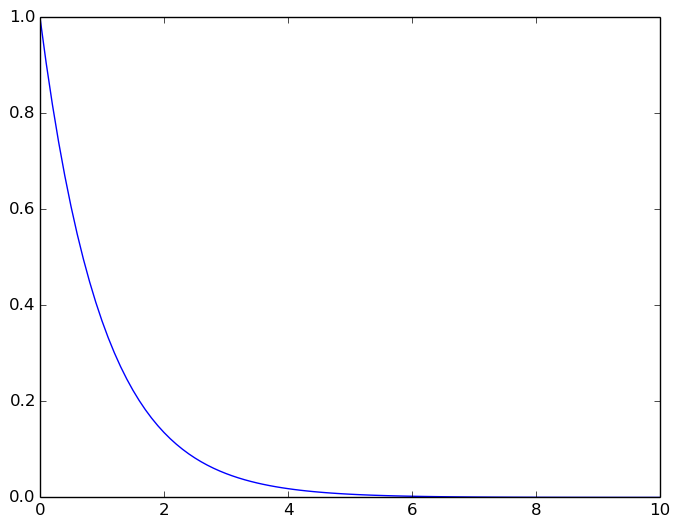

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f088530f510>

In [26]:
plot(t, soln)

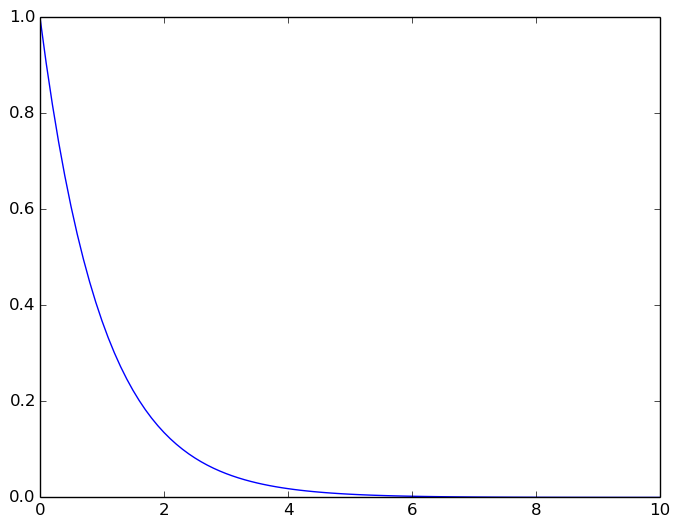

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f0885188fd0>

In [27]:
plot(t, exp(-t))

## Subtle difference from Python

Accessing fields (properties) and methods of Python objects uses the `obj.a` and `obj.b()` syntax, where `obj` is a Python object.
However, currently the `obj.b` syntax in Julia is restricted to accessing fields of Julia composite types.

For this reason, to access fields and methods of Python objects via PyCall, it is necessary to use the syntax

`obj[:a]` for fields, and

`obj[:a]()` for methods

Here, we are using the Julia syntax `:a` to mean the Julia symbol `a`.

## Lower level

The high-level `PyCall` interface is built on top of a lower-level interface which deals with the "transport" of objects between Python and Julia, based on a `PyObject` Julia type that wraps `PyObject*` in C, and represents a reference to a Python object.



In [28]:
PyObject(3)

PyObject 3

In [29]:
x = rand(5, 5)

5×5 Array{Float64,2}:
 0.192817  0.946536  0.14998    0.513158  0.386115
 0.780035  0.152082  0.230974   0.757223  0.225672
 0.709357  0.434981  0.0691486  0.815286  0.827455
 0.112237  0.900613  0.837933   0.601066  0.947075
 0.77884   0.889817  0.840832   0.717631  0.952602

In [30]:
px = PyObject(x)

PyObject array([[ 0.19281677,  0.9465357 ,  0.14998042,  0.51315761,  0.38611481],
       [ 0.78003545,  0.15208209,  0.23097367,  0.75722312,  0.22567229],
       [ 0.70935652,  0.43498077,  0.06914856,  0.81528566,  0.82745457],
       [ 0.11223706,  0.9006128 ,  0.83793259,  0.60106603,  0.94707501],
       [ 0.77883963,  0.88981653,  0.84083227,  0.71763108,  0.95260162]])

In [31]:
typeof(px)

PyCall.PyObject

In [33]:
fieldnames(px)

1-element Array{Symbol,1}:
 :o

In [34]:
px.o

Ptr{PyCall.PyObject_struct} @0x0000000005857970

In [35]:
# px.shape  in Python becomes:
px[:shape]

(5,5)

In [36]:
typeof(ans)  # the result has already been translated back into a Julia object

Tuple{Int64,Int64}

Julia arrays are passed into Python without a copy. By default the resulting Python array is copied when a result is requested in Julia; this can be avoided at a lower level using `pycall` and `PyArray`.

**Exercise**: Use your favorite Python package from Julia!